# Deep Residual U-Net (ResUNet)
It is specially designed for road extraction image from aerial view.

## Imports

In [77]:
import cv2
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import tensorflow as tf

from PIL import Image
from sklearn.model_selection import train_test_split

## Building Model

### Batchnormalization and Activation layer in one block

In [2]:
def bn_act(x, activation=True):
    x = tf.keras.layers.BatchNormalization()(x)
    if activation:
        x = tf.keras.layers.Activation("relu")(x)
    return x

### Convolution block of Res-Unet

In [3]:
def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

### Starting Layers

In [4]:
def starting_block(x, filters, kernel_size = (3, 3), padding="same", strides=1):
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, activation=False)
    
    output = tf.keras.layers.Add()([conv, shortcut])
    return output

### Residual Block

In [5]:
def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, activation=False)
    
    output = tf.keras.layers.Add()([shortcut, res])
    return output

### Upsampling and Concatenation Block

In [6]:
def upsample_concat_block(x, xskip):
    upsample = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([upsample, xskip])
    return concat

## Complete Residual U-Net

In [7]:
def resUnet(filters, input_shape):
    input_data = tf.keras.layers.Input(shape=input_shape)
    
    ## Encoder (encoding path)
    encoder_0 = input_data
    encoder_1 = starting_block(encoder_0, filters[0])
    encoder_2 = residual_block(encoder_1, filters[1], strides=2)
    encoder_3 = residual_block(encoder_2, filters[2], strides=2)
    encoder_4 = residual_block(encoder_3, filters[3], strides=2)
    encoder_5 = residual_block(encoder_4, filters[4], strides=2)
    
    ## Bridge (connects encoder and decoder)
    bridge_0 = conv_block(encoder_5, filters[4], strides=1)
    bridge_1  = conv_block(bridge_0 , filters[4], strides=1)
    
    ## Decoder (decoding path)
    upsample_1 = upsample_concat_block(bridge_1, encoder_4)
    decoder_1 = residual_block(upsample_1, filters[4])
    
    upsample_2 = upsample_concat_block(decoder_1, encoder_3)
    decoder_2 = residual_block(upsample_2, filters[3])
    
    upsample_3 = upsample_concat_block(decoder_2, encoder_2)
    decoder_3 = residual_block(upsample_3, filters[2])
    
    upsample_4 = upsample_concat_block(decoder_3, encoder_1)
    decoder_4 = residual_block(upsample_4, filters[1])
    
    output_data = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(decoder_4)
    model = tf.keras.models.Model(inputs=input_data, outputs=output_data, name="ResU-Net")
    return model
    

In [8]:
f = [16, 32, 64, 128, 256]
input_shape = (128, 128, 3)
model = resUnet(f, input_shape)

In [9]:
model.summary()

Model: "ResU-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
___________________________________________________________________________________________

## Data Pipline

In [21]:
dataset_path = "dataset/salt-identification/"
train_path = "dataset/salt-identification/train/"

In [22]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, "masks", id_name) + ".png"
        
        ## Reading Image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        ##Reading Mask
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(mask, axis=-1)
        
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Setting the hyper parameters

In [23]:
train_csv = pd.read_csv(dataset_path + "train.csv")
train_ids = train_csv["id"].values

image_size = 128
batch_size = 16

val_data_size = 200

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [24]:
train_ids[0]

'3edc3edf92'

In [25]:
generator = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = generator.__getitem__(0)
print(x.shape, y.shape)

(16, 128, 128, 3) (16, 128, 128, 1)


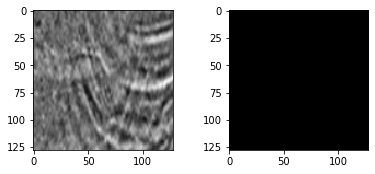

In [31]:
idx = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[idx])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[idx]*255, (image_size, image_size)), cmap="gray")

## Loss function

In [44]:
smooth = 1
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [50]:
def dice_coefficient_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

In [55]:
#model.compile(optimizer='adam', loss=dice_coefficient_loss, metrics=[dice_coefficient])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [52]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

epochs = 1

In [57]:
#model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,epochs=epochs)

In [61]:
"""
print("\n      Ground Truth            Predicted Value")
for i in range(1, 5, 1):
    ## Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.4
        
    for i in range(len(result)):
        fig = plt.figure()
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(np.reshape(y[i]*255, (image_size, image_size)), cmap="gray")

        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.reshape(result[i]*255, (image_size, image_size)), cmap="gray")
"""

'\nprint("\n      Ground Truth            Predicted Value")\nfor i in range(1, 5, 1):\n    ## Dataset for prediction\n    x, y = valid_gen.__getitem__(i)\n    result = model.predict(x)\n    result = result > 0.4\n        \n    for i in range(len(result)):\n        fig = plt.figure()\n        fig.subplots_adjust(hspace=0.4, wspace=0.4)\n\n        ax = fig.add_subplot(1, 2, 1)\n        ax.imshow(np.reshape(y[i]*255, (image_size, image_size)), cmap="gray")\n\n        ax = fig.add_subplot(1, 2, 2)\n        ax.imshow(np.reshape(result[i]*255, (image_size, image_size)), cmap="gray")\n'

## Lets train in IBSB dataset

In [64]:
masks = glob.glob("./dataset/isbi2015/train/label/*.png")
images = glob.glob("./dataset/isbi2015/train/image/*.png")


In [66]:
imgs_list = []
masks_list = []
for image, mask in zip(images, masks):
    imgs_list.append(np.array(Image.open(image).resize((512,512))))
    
    im = Image.open(mask).resize((512,512))
    masks_list.append(np.array(im))

In [68]:
images_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

In [71]:
print(images_np.shape, masks_np.shape)

(30, 512, 512) (30, 512, 512)


In [72]:
x = np.asarray(images_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)/255


In [73]:
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)

In [74]:
x.shape

(30, 512, 512, 1)

In [75]:
y.shape

(30, 512, 512, 1)

In [76]:
np.save("x", x)
np.save("y", y)

In [78]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)

In [79]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (27, 512, 512, 1)
y_train:  (27, 512, 512, 1)
x_val:  (3, 512, 512, 1)
y_val:  (3, 512, 512, 1)


### Training without augmentation

In [80]:
def iou(y_true, y_pred, smooth=1.):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection + smooth)


In [84]:
f = [16, 32, 64, 128, 256]
input_shape = (512, 512, 1)
model = resUnet(f, input_shape)

In [85]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    metrics=[iou, dice_coefficient]
)

In [ ]:
model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs=20)

Epoch 1/20
